# 聚类

## KMeans 聚类

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random
import numpy as np
from sklearn.preprocessing import MinMaxScaler # 归一化处理
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 对上节课爬取的POI数据进行预处理 具体结果如下 保证有location字段 ???
# 示例数据，请保证location格式与示例数据相同
# your code
df = pd.read_csv("./dinner.csv")
df = df.drop('Unnamed: 0', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      162 non-null    object
 1   location  162 non-null    object
 2   distance  162 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 3.9+ KB


In [3]:
df.head()

,name,location,distance
0,深技大·润园咖啡(竹韵花园店),"114.399915,22.702838",14
1,深圳技术大学湖景餐厅,"114.398261,22.701848",216
2,TOM BAR,"114.402527,22.701955",272
3,技大阿叔炒粉,"114.402772,22.702329",285
4,鸿儒烤吧,"114.402700,22.701929",290


In [4]:
# df处理成如下格式
# your code
df['longitude'] = df['location'].apply(lambda x: x.split(',')[0])
df['latitude'] = df['location'].apply(lambda x: x.split(',')[1])
df = df.drop('location', axis=1)
df.head()

,name,distance,longitude,latitude
0,深技大·润园咖啡(竹韵花园店),14,114.399915,22.702838
1,深圳技术大学湖景餐厅,216,114.398261,22.701848
2,TOM BAR,272,114.402527,22.701955
3,技大阿叔炒粉,285,114.402772,22.702329
4,鸿儒烤吧,290,114.402700,22.701929


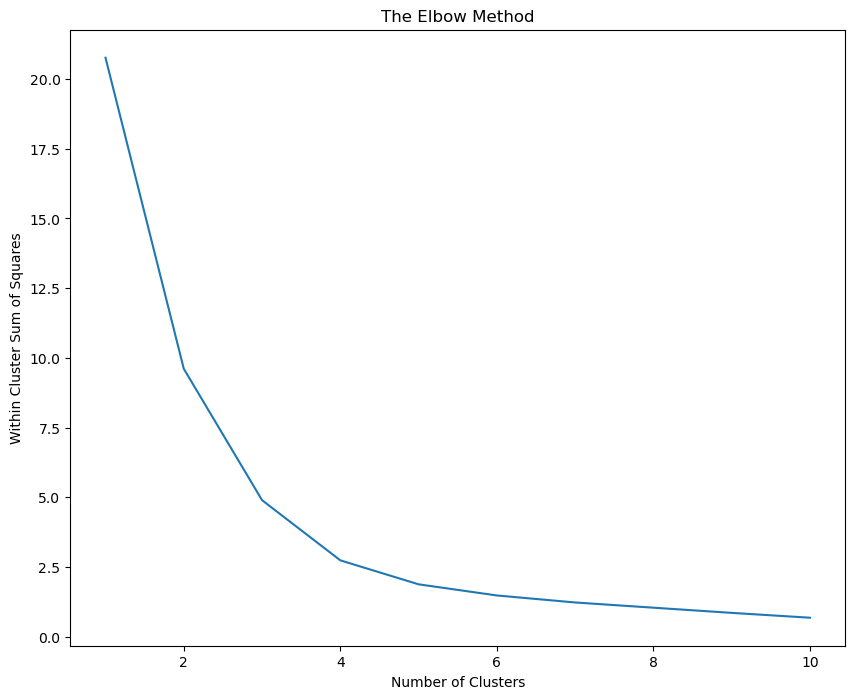

In [55]:
# 肘部取值法 并给出应该选择k的大小 (找到最佳聚类数)
# your code 

df2 = df[['longitude', 'latitude']]
scaler = MinMaxScaler()
df2 = scaler.fit_transform(df2)
df2 = pd.DataFrame(df2) # 转换成dataframe


cluster_num = []
plt.figure(figsize=(10, 8))
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42) # kmeans++ 选择初始质心
    kmeans.fit(df2)
    wcss.append(kmeans.inertia_)
    cluster_num.append(i)
plt.plot(cluster_num, wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.show()

In [38]:


# 计算欧拉距离
def calcDis(dataSet, centroids, k):
    clalist=[] # 存储每个数据点到质心的距离
    # 遍历数据集中的每个数据点
    for data in dataSet:
        # your code
        # 1. 计算数据点与所有质心之间的差值
        # 2. 计算差值的平方
        # 3. 沿着列方向求和，得到每个数据点与所有质心的平方距离
        # 4. 开根号，得到每个数据点到所有质心的欧拉距离
        # 5. 将距离添加到列表中
        # dis = np.sum((data - centroids)**2, axis=1)**0.5 
        dis = np.sum((np.array(data) - np.array(centroids))**2, axis=1)**0.5
        clalist.append(dis)
    clalist = np.array(clalist)
    # 将列表转换为NumPy数组，并返回
    return clalist



In [34]:
# 计算质心
def classify(dataSet, centroids, k):
    # 1. 计算样本到质心的距离
    clalist = calcDis(dataSet, centroids, k)

    # 2. 根据距离最近的质心将样本分组(对dataSet分组，groupby(min)按照min进行统计分类，mean()对分类结果求均值)，并计算新的质心
    minDistIndices = np.argmin(clalist, axis=1)
    newCentroids = pd.DataFrame(dataSet).groupby(minDistIndices).mean()
    newCentroids = newCentroids.values
    
    # 3. 计算质心的变化量
    changed = newCentroids - centroids

    # 4. 返回质心的变化量changed以及更新后的质心newCentroids
    return changed, newCentroids

In [35]:
# 使用k-means分类
def kmeans(dataSet, k):
    # 1. 随机选择k个质心
    centroids = random.sample(dataSet, k)
    # 2. 更新质心，直到质心的变化量为0
    changed, newCentroids = classify(dataSet, centroids, k)
    while np.any(changed != 0):
        changed, newCentroids = classify(dataSet, newCentroids, k)


    # 3. 对质心进行排序，并将其转换为列表形式
    newCentroids = sorted(newCentroids.tolist())
    # 4. 根据质心计算每个聚类
    #   4.1 创建cluster空列表，用于存储每个聚类的数据点
    cluster = []
    #   4.2 计算数据集中每个数据点与质心的欧拉距离，得到一个距离矩阵 clalist
    clalist = calcDis(dataSet, newCentroids, k)
    #   4.3 找到每个数据点距离最近的质心的索引，即确定每个数据点所属的聚类。
    minDistIndices = np.argmin(clalist, axis=1)
    #   4.4 遍历质心的索引，对于每个索引创建一个空列表，并将其添加到 cluster 列表中（cluster 列表的长度就等于聚类的个数 k）
    for i in range(k):
        cluster.append([])
    #   4.5 循环遍历数据点的索引和对应的质心索引。在每次迭代中，将当前数据点添加到相应质心索引对应的聚类中。
    for j in range(len(minDistIndices)):
        cluster[minDistIndices[j]].append(dataSet[j])
    # 5. 最后返回质心列表centroids 和 聚类结果 cluster以及 每个数据点所属聚类的索引的数组minDistIndices
    
    # -----------------------------------
    # your code (请完成步骤3~5)  写完了
    # -----------------------------------
    
    return centroids, cluster, minDistIndices

In [36]:
# 创建数据集
def createDataSet():
    # your code
    # 1. 读取自己爬取的POI数据
    # 2. 将location分成latitude、longitude两列
    # 3. 归一化处理:
    # 4. 返回一个二维数组 n*2的数组 [[latitude, longitude], [], [], [], []] 
    
    scaled_coordinates = scaler.fit_transform(df2)
    
    scaled_coordinates = pd.DataFrame(scaled_coordinates)
    scaled_coordinates.columns = ['longitude', 'latitude']
    return scaled_coordinates


In [29]:
dataset = createDataSet()
dataset

,longitude,latitude
0,0.614264,0.135392
1,0.493771,0.041330
2,0.804546,0.051496
3,0.822394,0.087031
4,0.817149,0.049026
...,...,...
157,0.364828,0.940143
158,0.666642,1.000000
159,0.331099,0.926081
160,0.446274,0.974917


质心为：[[0.3885772565026855, 0.9506888361042911], [0.33386756028266973, 0.8942517814725761], [0.9377139943171642, 0.7370071258906137]]
集群为：[[[0.0, 0.5343467933494139], [0.008231951629568357, 0.5379572446554448], [0.028993953521421645, 0.5274109263659739], [0.0365702629860607, 0.5104038004751601], [0.03861003861129575, 0.5045130641333344], [0.045894951555965235, 0.5172446555820898], [0.06855103081579728, 0.444940617577231], [0.07015371166380646, 0.4238479809978344], [0.07678298244354664, 0.4257482185275876], [0.08020689152726845, 0.6655581947748033], [0.08720040795560635, 0.4192874109262448], [0.09026007139254943, 0.4133966745844191], [0.09106141181655403, 0.5420427553444824], [0.10104174255138787, 0.729501187648566], [0.11298899978100962, 0.734821852731784], [0.12063815837427683, 0.6647030878862097], [0.12224083922228601, 0.6604275534441513], [0.12406206745799864, 0.6524465558195516], [0.1251548044001538, 0.65092636579584], [0.17410941939306213, 0.5406175771972812], [0.17461936329891614, 

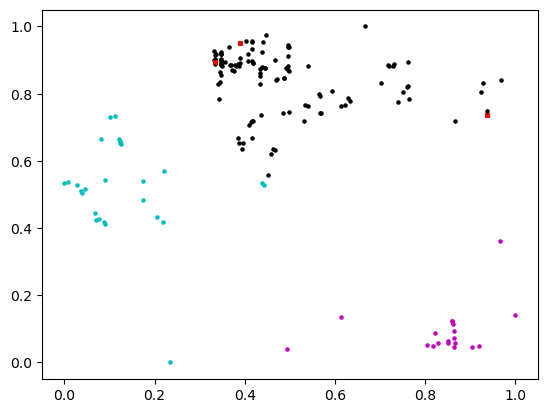

In [39]:
def start():
    dataset = createDataSet()
    # Population must be a sequence.  For dicts or sets, use sorted(d).
    dataset = sorted(dataset.values.tolist()) # 将数据集转换为列表
    # yourc ode k的取值 通过肘部取值法 自行判断
    k = 3
    centroids, cluster, minDistIndices = kmeans(dataset, k)
    print('质心为：%s' % centroids)
    print('集群为：%s' % cluster)
    for i in range(len(dataset)):
        plt.scatter(dataset[i][0], dataset[i][1], marker='o', color=get_color(minDistIndices[i]), s=5, label='原始点')

    for j in range(len(centroids)):
        plt.scatter(centroids[j][0], centroids[j][1], marker='x', color='red', s=10, label='质心')
    plt.show()


def get_color(cluster_index):
    colors = ['c', 'k', 'm', 'b']  # 每个类别对应的颜色
    return colors[cluster_index % len(colors)]  # 根据聚类索引获取对应的颜色

# 由于起始点是随机选取的 有时候会出现报错。在前面代码无误的情况下，再次运行即可
start()

## 密度聚类-DBSCAN

聚类个数为：3
轮廓系数: 0.505


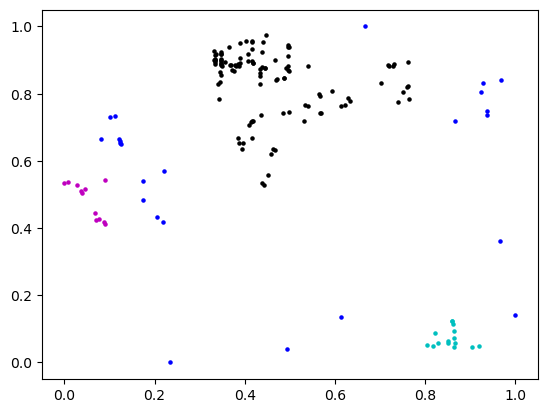

In [41]:
# 使用DBSCAN对自己的数据集进行密度聚类（ 例如对POI数据经纬度进行密度聚类
# your code
from sklearn.cluster import DBSCAN
from sklearn import metrics

# 对POI数据经纬度进行密度聚类
# eps = 0.1
# min_samples = 10
# db = DBSCAN(eps=eps, min_samples=min_samples).fit(dataset2)
def start2():
    dataset2 = createDataSet()
    dataset2 = dataset2.values.tolist()
    eps = 0.1
    min_samples = 10
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(dataset2)
    labels = db.labels_ # 获取聚类标签
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) # 获取聚类个数
    
    print('聚类个数为：%s' % n_clusters_)
    print("轮廓系数: %0.3f" % metrics.silhouette_score(dataset2, labels))
    # 绘制聚类结果
    for i in range(len(dataset2)):
        plt.scatter(dataset2[i][0], dataset2[i][1], marker='o', color=get_color(labels[i]), s=5, label='原始点')
    plt.show()    
start2()

## 层次聚类

In [42]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import scipy.cluster.hierarchy as sch # 导入层次聚类算法
from sklearn.cluster import AgglomerativeClustering 

ourData = pd.read_csv('Mall_Customers.csv')

### 对数据3：4列进行层次聚类

In [43]:
newData = ourData.iloc[:, [3, 4]].values
newData 

array([[ 15,  39],
   [ 72,  34],
       [ 72,  71],
        5],
       [ 81,  93],
       [ 85,  26],
       [ 85,  75],
       [ 86,  20],
       [ 86,  95],
       [ 87,  27],
       [ 87,  63],
       [ 87,  13],
       [ 87,  75],
       [ 87,  10],
       [ 87,  92],
       [ 88,  13],
       [ 88,  86],
       [ 88,  15],
       [ 88,  69],
       [ 93,  14],
       [ 93,  90],
       [ 97,  32],
       [ 97,  86],
       [ 98,  15],
       [ 98,  88],
       [ 99,  39],
       [ 99,  97],
       [101,  24],
       [101,  68],
       [103,  17],
       [103,  85],
       [103,  23],
       [103,  69],
       [113,   8],
       [113,  91],
       [120,  16],
       [120,  79],
       [126,  28],
       [126,  74],
       [137,  18],
       [137,  83]], dtype=int64)

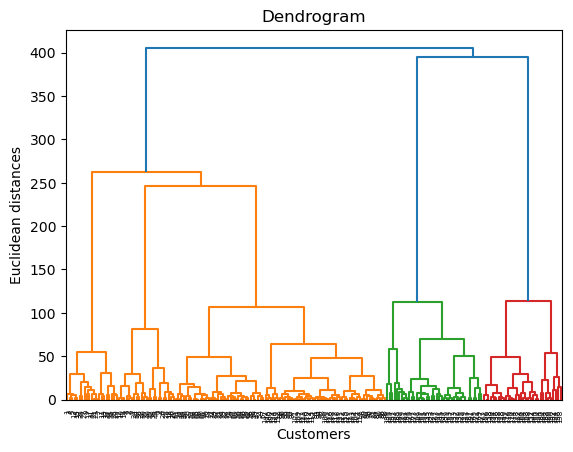

In [52]:
# 使用树状图找到最佳聚类数
# your code
def start3():
    dendrogram = sch.dendrogram(sch.linkage(newData, method='ward'))
    plt.title('Dendrogram')
    plt.xlabel('Customers')
    plt.ylabel('Euclidean distances')
    plt.show()
start3() # 树状图的横轴是样本点，纵轴是样本点之间的距离，树状图的高度代表样本点之间的距离.树状图中最长的垂直线与横轴相交的点的个数就是聚类的个数
# 5

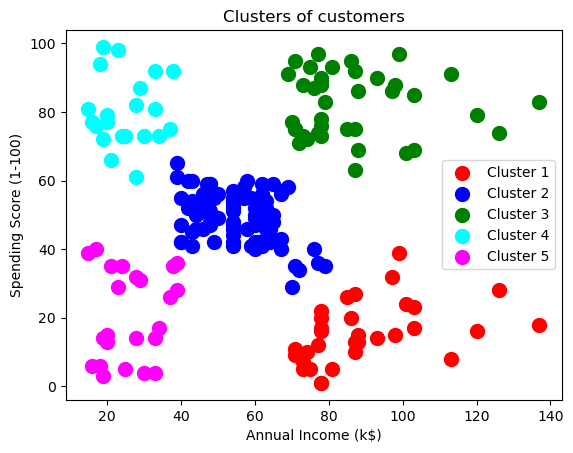

In [56]:
# 数据进行层次聚类并画出图像
# your code
def start4():
    hc = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
    y_hc = hc.fit_predict(newData)
    plt.scatter(newData[y_hc == 0, 0], newData[y_hc == 0, 1], s=100, c='red', label='Cluster 1')
    plt.scatter(newData[y_hc == 1, 0], newData[y_hc == 1, 1], s=100, c='blue', label='Cluster 2')
    plt.scatter(newData[y_hc == 2, 0], newData[y_hc == 2, 1], s=100, c='green', label='Cluster 3')
    plt.scatter(newData[y_hc == 3, 0], newData[y_hc == 3, 1], s=100, c='cyan', label='Cluster 4')
    plt.scatter(newData[y_hc == 4, 0], newData[y_hc == 4, 1], s=100, c='magenta', label='Cluster 5')
    plt.title('Clusters of customers')
    plt.xlabel('Annual Income (k$)')
    plt.ylabel('Spending Score (1-100)')
    plt.legend()
    plt.show()
start4() # END